# Notebook to make Fig. 5

In [18]:
# Import necessary packages & set-up plotting aesthetics

import numpy as np 
import pylab
import pandas as pd

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.lines import Line2D

from fig_helper_functions import *

style.use('plotting.mplstyle')

import seaborn as sns
sns.set_palette('colorblind')

### Load data

In [2]:
f_root = '../Data/InjectedPopulationParameters/' 

pop1_underlying = pd.read_json(f_root+'underlying_population1_highSpinPrecessing_fullmassrange.json')
pop2_underlying = pd.read_json(f_root+'underlying_population2_mediumSpin_fullmassrange.json')
pop3_underlying = pd.read_json(f_root+'underlying_population3_lowSpinAligned_fullmassrange.json')

pop1_detected = pd.read_json(f_root+'population1_highSpinPrecessing_fullmassrange.json')
pop2_detected = pd.read_json(f_root+'population2_mediumSpin_fullmassrange.json')
pop3_detected = pd.read_json(f_root+'population3_lowSpinAligned_fullmassrange.json')

Condition into dict

In [4]:
mass_redshift_dict = {
    
    'underlying': {
        'm1':np.concatenate([pop1_underlying.m1, pop2_underlying.m1, pop3_underlying.m1]), 
        'm2':np.concatenate([pop1_underlying.m2, pop2_underlying.m2, pop3_underlying.m2]),
        'z':np.concatenate([pop1_underlying.z, pop2_underlying.z, pop3_underlying.z]), 
    }, 
    
    'detected': {
        'm1':np.concatenate([pop1_detected.m1, pop2_detected.m1, pop3_detected.m1]), 
        'm2':np.concatenate([pop1_detected.m2, pop2_detected.m2, pop3_detected.m2]), 
        'z':np.concatenate([pop1_detected.z, pop2_detected.z, pop3_detected.z]),
    }
}

### Plot spin parameters for each population

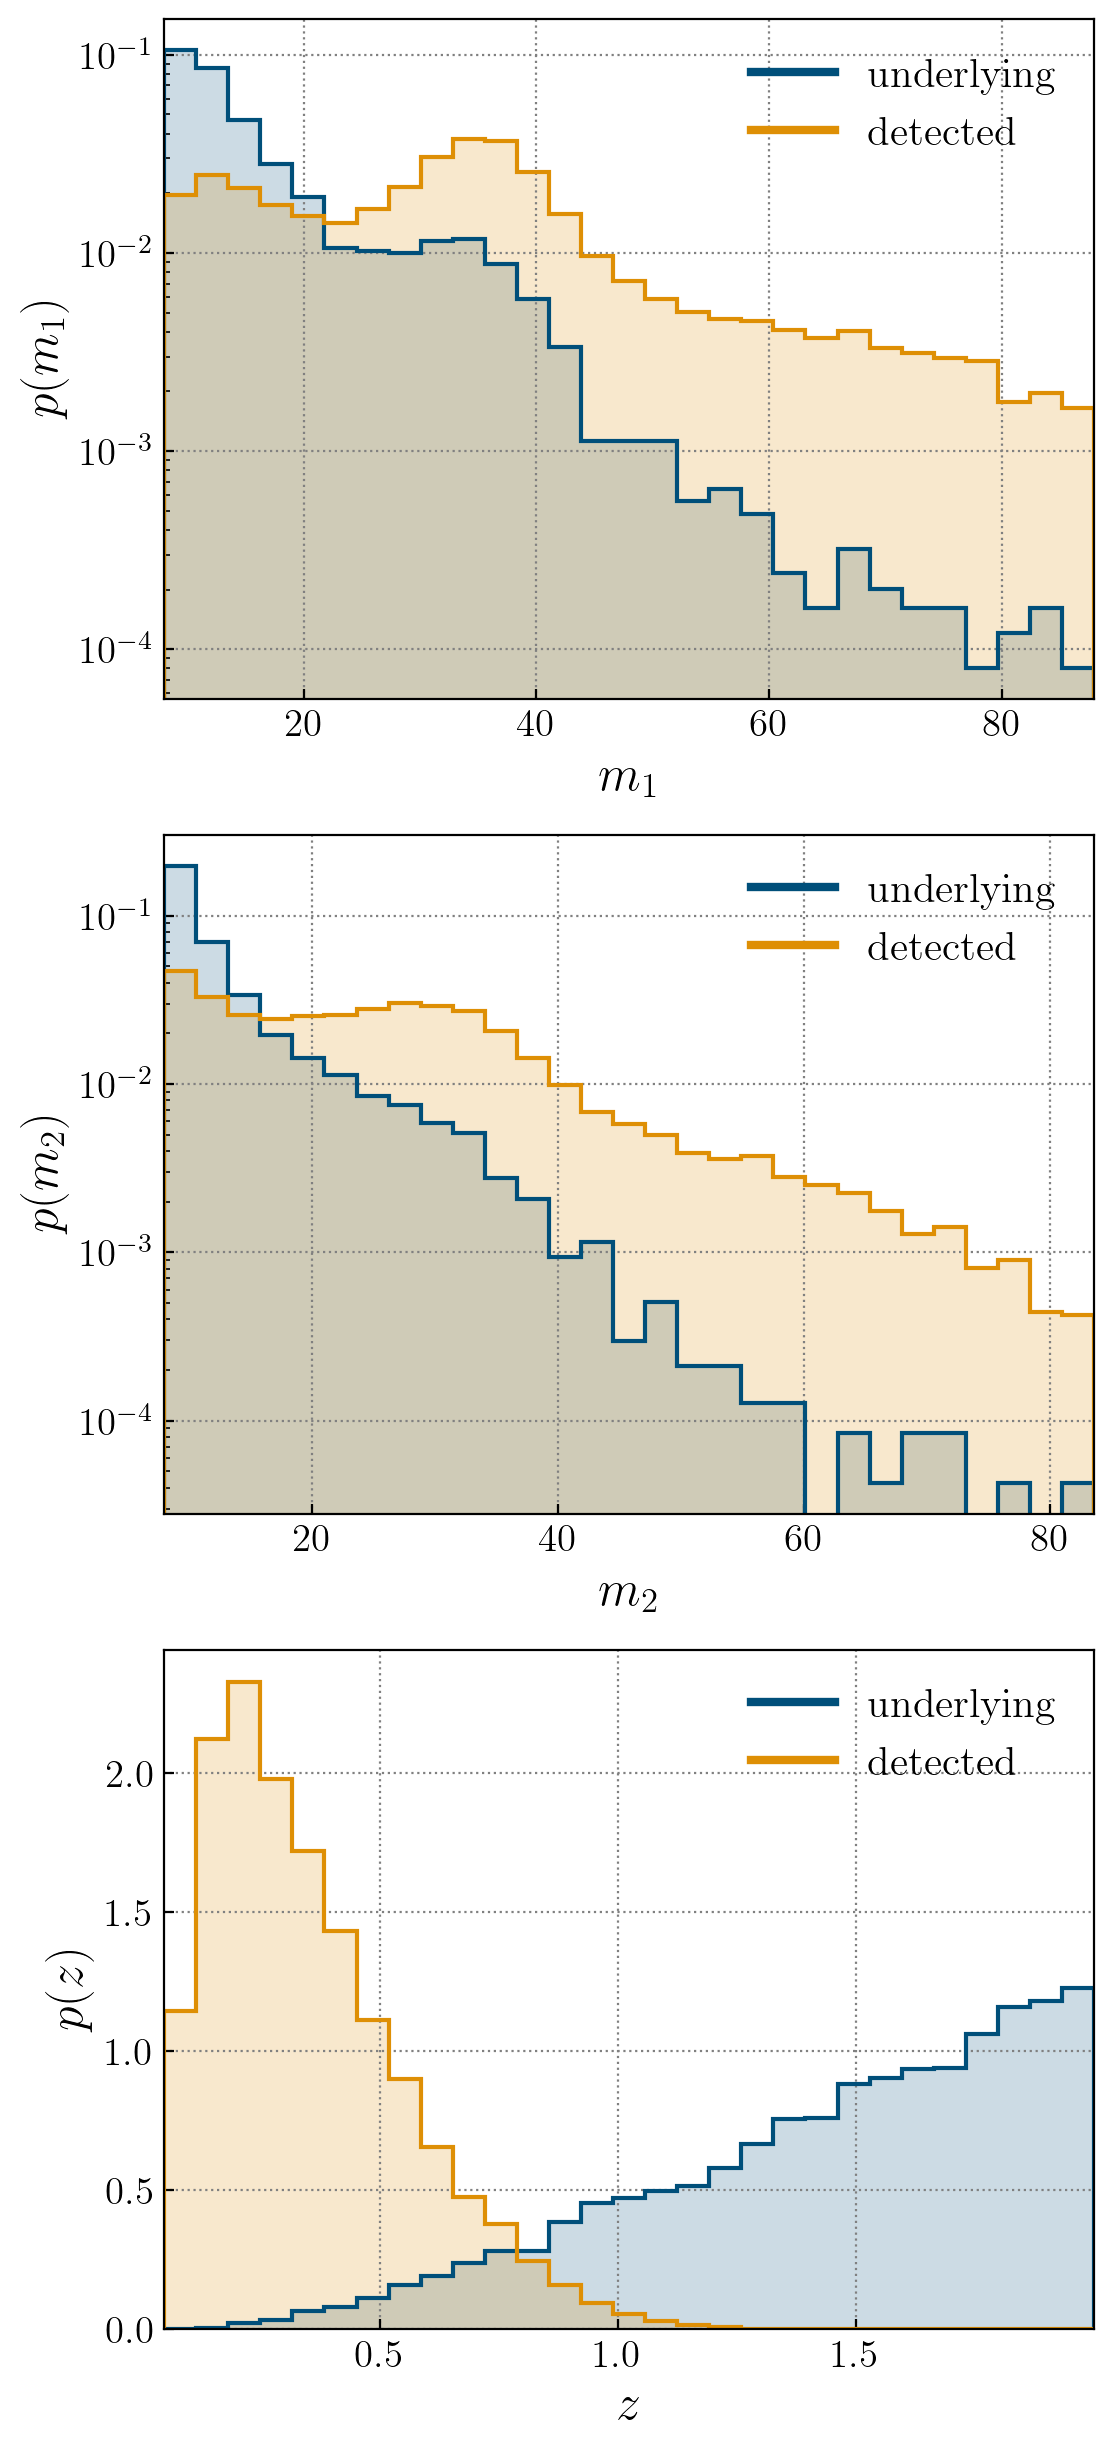

In [28]:
colors = ['#004f7a', 'C1']

plt.figure(figsize=(6, 15))
subplt_num = 311

for param, lbl in zip(['m1', 'm2', 'z'], ['m_1', 'm_2', 'z']): 
    
    plt.subplot(subplt_num)
        
    # underlying dist
    mask1 = (mass_redshift_dict['underlying']['m1'] > 8) & (mass_redshift_dict['underlying']['m2'] > 8)
    underlying = mass_redshift_dict['underlying'][param][mask1]
    
    bins = np.linspace(min(underlying), max(underlying), 30)
    
    plt.hist(underlying, density=True, color=colors[0], bins=bins, histtype='step', lw=1.5, label='underlying')
    plt.hist(underlying, density=True, color=colors[0], bins=bins, alpha=0.2, lw=1.5)
    
    # detected dist
    mask2 = (mass_redshift_dict['detected']['m1'] > 8) & (mass_redshift_dict['detected']['m2'] > 8)
    detected = mass_redshift_dict['detected'][param][mask2]
    
    plt.hist(detected, density=True, color=colors[1], bins=bins, histtype='step', lw=1.5, label='detected')
    plt.hist(detected, density=True, color=colors[1], bins=bins, alpha=0.2, lw=1.5)
    
    plt.xlim(bins[0], bins[-1])
    plt.xlabel(f'${lbl}$')
    plt.ylabel(f'$p({lbl})$')
    
    #legend 
    handles = [Line2D([], [], color=colors[i], label=l) for i,l in enumerate(['underlying', 'detected'])]
    leg = plt.legend(handles=handles, fontsize=15)
    for i, h in enumerate(handles):
        leg.get_lines()[i].set_linewidth(3)
        
    if 'm' in param: 
        plt.yscale('log')
        
    subplt_num+=1
    
plt.savefig('figure_05.pdf',bbox_inches='tight')
plt.show()